# MoE


In [138]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output
import time
import itertools
import os 
import sys


notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from moe_model import MoE as MoE_raw, MLP as MoE_Expert

# --- Helper class to modify the MoE Expert to output raw logits ---
# This is necessary because the CrossEntropyLoss function expects logits, not probabilities.
class MoE_Expert_Logits(MoE_Expert):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__(input_size, output_size, hidden_size)
        # Replace the final softmax layer with an identity layer
        self.soft = nn.Identity()


In [139]:
def train_and_evaluate_trial(params, X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a single trial of the MoE model with a given set of hyperparameters.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # --- Model Configuration ---
    model = MoE_raw(
        input_size=X_train.shape[1],
        output_size=2,
        num_experts=params['num_experts'],
        hidden_size=params['hidden_size'],
        k=params['k']
    )
    model.experts = nn.ModuleList([
        MoE_Expert_Logits(
            input_size=X_train.shape[1],
            output_size=2,
            hidden_size=params['hidden_size']
        ) for _ in range(model.num_experts)
    ])
    model.to(device)
    
    # --- Data Preparation ---
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)

    # --- Training with Early Stopping ---
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    patience = 5
    best_val_loss = float('inf')
    patience_counter = 0
    max_epochs = 75

    for epoch in range(max_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred, aux_loss = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor) + aux_loss
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_val_pred, val_aux_loss = model(X_val_tensor)
            val_loss = criterion(y_val_pred, y_val_tensor) + val_aux_loss
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            break

    # --- Final Evaluation on Validation Set ---
    model.eval()
    with torch.no_grad():
        y_pred_tensor, _ = model(X_val_tensor)
        probas = nn.functional.softmax(y_pred_tensor, dim=1)
        _, predicted = torch.max(probas, 1)
        
        y_true = y_val_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_score = probas[:, 1].cpu().numpy()
        
        # Get detailed metrics from classification report for class '1'
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0).get('1', {})

        return {
            'num_experts': params['num_experts'],
            'hidden_size': params['hidden_size'],
            'k': params['k'],
            'val_roc_auc': roc_auc_score(y_true, y_score),
            'val_accuracy': accuracy_score(y_true, y_pred),
            'val_f1_score': report.get('f1-score', 0),
            'val_precision': report.get('precision', 0),
            'val_recall': report.get('recall', 0),
            'val_cohen_kappa': cohen_kappa_score(y_true, y_pred)
        }


In [140]:
# --- 1. Load and Prepare Data ---
try:
    print("🔹 Loading and preparing data...")
    filename = 'uk_biobank_dataset.csv'
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    file_path = os.path.join(parent_dir, filename)
    df = pd.read_csv(file_path, low_memory=False)
    X = df.drop(columns=['Dementia Status'])
    y = df['Dementia Status']
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Data loaded successfully. Train shape: {X_train.shape}")
except FileNotFoundError:
    print("\n⚠️ ERROR: 'input_data.csv' not found. Please run the feature extractor first.")
    # In a notebook, you might want to stop execution here if the file is not found.

# --- 2. Define the Hyperparameter Grid ---
param_grid = {
    'num_experts': [3, 4, 6, 8],
    'hidden_size': [16, 32, 64],
    'k': [2, 3, 4]
}

# Create all possible combinations
all_params = list(itertools.product(
    param_grid['num_experts'],
    param_grid['hidden_size'],
    param_grid['k']
))

# Filter out invalid combinations where k > num_experts
valid_params = [
    {'num_experts': p[0], 'hidden_size': p[1], 'k': p[2]}
    for p in all_params if p[2] <= p[0]
]

print(f"\n🔹 Starting Grid Search. Total combinations to test: {len(valid_params)}")


🔹 Loading and preparing data...
Data loaded successfully. Train shape: (1297, 64)

🔹 Starting Grid Search. Total combinations to test: 33


In [141]:

# --- 3. Run the Grid Search ---
results = []
for i, params in enumerate(valid_params):
    print(f"\n--- Testing Combination {i+1}/{len(valid_params)} ---")
    print(f"Parameters: {params}")
    
    result = train_and_evaluate_trial(params, X_train_scaled, y_train.values, X_val_scaled, y_val.values)
    results.append(result)
    
    # Live update of results
    clear_output(wait=True)
    # --- CHANGE: Sort by F1-score ---
    results_df = pd.DataFrame(results).sort_values('val_f1_score', ascending=False)
    print("✅ Intermediate Tuning Results (Validation Set):")
    display(results_df)

# --- 4. Final Evaluation on Test Set ---
print("\n\n" + "="*40 + "\n✅ FINAL EVALUATION ON HELD-OUT TEST SET\n" + "="*40)

# Get the best parameters from the grid search
best_params = results_df.iloc[0].to_dict()
print("🏆 Best Hyperparameters found (based on validation F1-score):")
print(f"  - Number of Experts: {int(best_params['num_experts'])}")
print(f"  - Hidden Size: {int(best_params['hidden_size'])}")
print(f"  - Top K: {int(best_params['k'])}")

# Combine training and validation data
X_train_val = np.concatenate((X_train_scaled, X_val_scaled), axis=0)
y_train_val = np.concatenate((y_train.values, y_val.values), axis=0)

print("\nRetraining the best model on combined Train+Validation data...")

# Create the final model with the best parameters
final_model = MoE_raw(
    input_size=X_train_val.shape[1],
    output_size=2,
    num_experts=int(best_params['num_experts']),
    hidden_size=int(best_params['hidden_size']),
    k=int(best_params['k'])
)
final_model.experts = nn.ModuleList([
    MoE_Expert_Logits(
        input_size=X_train_val.shape[1],
        output_size=2,
        hidden_size=int(best_params['hidden_size'])
    ) for _ in range(final_model.num_experts)
])

# Train the final model and evaluate on the test set
final_results = train_and_evaluate_trial(
    {'num_experts': int(best_params['num_experts']), 'hidden_size': int(best_params['hidden_size']), 'k': int(best_params['k'])},
    X_train_val, y_train_val, X_test_scaled, y_test.values
)

# --- CHANGE: Print all requested metrics for the final evaluation ---
print("\n--- Final Performance on Test Set ---")
print(f"  - Accuracy:    {final_results['val_accuracy']:.4f}")
print(f"  - ROC-AUC:     {final_results['val_roc_auc']:.4f}")
print(f"  - F1-Score:    {final_results['val_f1_score']:.4f}")
print(f"  - Precision:   {final_results['val_precision']:.4f}")
print(f"  - Recall:      {final_results['val_recall']:.4f}")
print(f"  - Cohen Kappa: {final_results['val_cohen_kappa']:.4f}")


✅ Intermediate Tuning Results (Validation Set):


,num_experts,hidden_size,k,val_roc_auc,val_accuracy,val_f1_score,val_precision,val_recall,val_cohen_kappa
2,3,32,2,0.779987,0.730216,0.752475,0.703704,0.808511,0.459144
31,8,64,3,0.778019,0.733813,0.750000,0.716129,0.787234,0.466743
13,4,64,3,0.784128,0.723022,0.745875,0.697531,0.801418,0.444721
19,6,32,3,0.773334,0.726619,0.739726,0.715232,0.765957,0.452557
28,8,32,3,0.767459,0.712230,0.735099,0.689441,0.787234,0.423147
22,6,64,3,0.775793,0.715827,0.732203,0.701299,0.765957,0.430771
29,8,32,4,0.780401,0.715827,0.732203,0.701299,0.765957,0.430771
26,8,16,4,0.768080,0.712230,0.731544,0.694268,0.773050,0.423386
3,3,32,3,0.780815,0.708633,0.730897,0.687500,0.780142,0.415997
23,6,64,4,0.783196,0.712230,0.729730,0.696774,0.765957,0.423506




✅ FINAL EVALUATION ON HELD-OUT TEST SET
🏆 Best Hyperparameters found (based on validation F1-score):
  - Number of Experts: 3
  - Hidden Size: 32
  - Top K: 2

Retraining the best model on combined Train+Validation data...

--- Final Performance on Test Set ---
  - Accuracy:    0.7626
  - ROC-AUC:     0.8188
  - F1-Score:    0.7708
  - Precision:   0.7500
  - Recall:      0.7929
  - Cohen Kappa: 0.5250




🚀 Starting SHAP Analysis for the Best Model
Calculating SHAP values... (This may take a moment)

--- SHAP Summary Plots ---


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


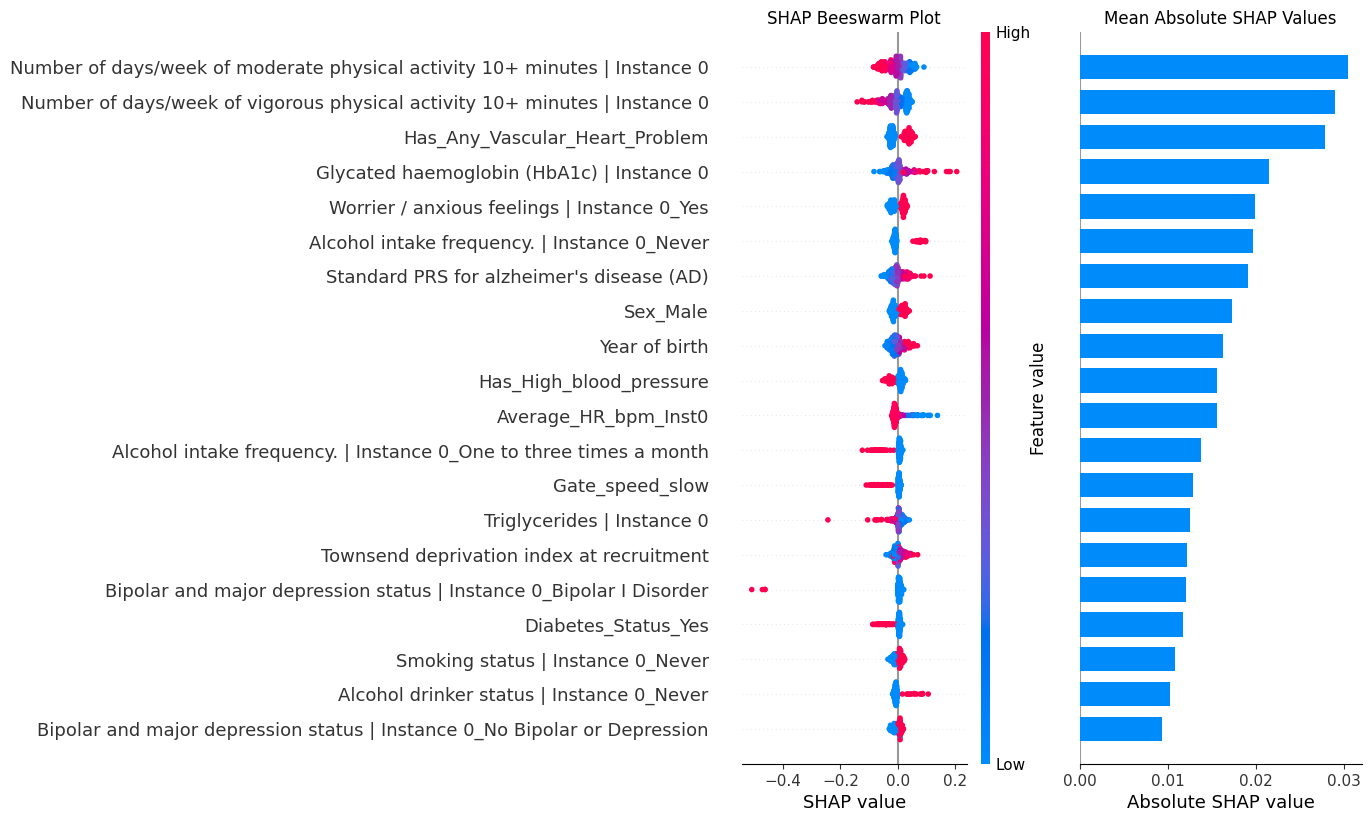

In [154]:
import shap
import matplotlib.pyplot as plt

# ===================================================================
# SHAP Analysis of the Final, Best Model
# ===================================================================
# This block should be run after the hyperparameter tuning is complete.
# It uses the 'final_model' and the scaled data from the previous cell.
# ===================================================================

print("\n\n" + "="*40 + "\n🚀 Starting SHAP Analysis for the Best Model\n" + "="*40)

# --- 1. Prepare the model and data for SHAP ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# The final_model is already trained and on the correct device.
# We just need to ensure it's in evaluation mode.
final_model.eval()

# SHAP needs a background dataset to compute expected values.
# We'll use a sample of the training data for this.
background_sample = shap.sample(X_train_scaled, 100)
background_tensor = torch.from_numpy(background_sample).float().to(device)

# We will explain the model's predictions on the test set.
test_tensor = torch.from_numpy(X_test_scaled).float().to(device)

# --- 2. Create a wrapper for the SHAP explainer ---
# This ensures SHAP correctly handles the PyTorch model.
class ShapModelWrapper(nn.Module):
    def __init__(self, model):
        super(ShapModelWrapper, self).__init__()
        self.model = model
    
    def forward(self, x):
        # Temporarily switch to train() mode for the forward pass
        # to allow the backward pass required by the explainer.
        self.model.train()
        pred, _ = self.model(x)
        return pred

shap_model_wrapper = ShapModelWrapper(final_model)

# Explicitly move the entire wrapper (including the model inside it) to the correct device.
shap_model_wrapper.to(device)


# --- 3. Calculate SHAP values ---
# We use GradientExplainer, which is robust for this type of model.
explainer = shap.GradientExplainer(shap_model_wrapper, background_tensor)

print("Calculating SHAP values... (This may take a moment)")
shap_values = explainer.shap_values(test_tensor)

# --- 4. Generate and display the summary plots ---
print("\n--- SHAP Summary Plots ---")
# For binary classification, we plot the SHAP values for the positive class (class 1)

# --- THIS IS THE FIX: Manually create subplots and control each one ---
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot 1: Beeswarm Plot
# Use plt.sca to set the current axis for SHAP to draw on
plt.sca(axes[0])
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="dot", show=False)
axes[0].set_title("SHAP Beeswarm Plot")
axes[0].set_xlabel("SHAP value")

# Plot 2: Bar Plot (Mean absolute values)
plt.sca(axes[1])
shap.summary_plot(shap_values[1], features=X_test_scaled, feature_names=X.columns, plot_type="bar", show=False)
axes[1].set_title("Mean Absolute SHAP Values")
# Manually remove the y-axis labels from the second plot
axes[1].set_ylabel('')
axes[1].set_yticklabels([])
axes[1].set_xlabel("Absolute SHAP value")

# Use the figure's tight_layout method for a final adjustment
fig.tight_layout()
plt.show()
